In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.impute import KNNImputer
from sklearn.linear_model import SGDRegressor, ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.metrics import *
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

import shap

pd.set_option('display.max_column',500)
pd.set_option('display.max_row',500)

df = pd.read_csv('buildings_nettoyer.csv')
df.head()

,Unnamed: 0,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity,AgeRangeBuilt,ParkingGFARate,BuildingGFARate,GFAPerFloor
0,0,NonResidential,Hotel,DOWNTOWN,47.61220,-122.33799,1.0,12,88434,0,88434,88434.0,0.0,0.0,60.0,84.300003,2003882.00,1276453.0,2.83,"(90, 100]",0.000000,1.000000,6802.615385
1,1,NonResidential,Hotel,DOWNTOWN,47.61317,-122.33393,1.0,11,103566,15064,88502,83880.0,15064.0,4622.0,61.0,97.900002,0.00,5145082.0,2.86,"(20, 30]",0.145453,0.854547,7375.166667
2,3,NonResidential,Hotel,DOWNTOWN,47.61412,-122.33664,1.0,10,61320,0,61320,61320.0,0.0,0.0,56.0,113.300003,2214446.25,1811213.0,4.67,"(90, 100]",0.000000,1.000000,5574.545455
3,4,NonResidential,Hotel,DOWNTOWN,47.61375,-122.34047,1.0,18,175580,62000,113580,123445.0,68009.0,0.0,75.0,118.699997,0.00,8803998.0,2.88,"(40, 50]",0.353115,0.646885,5977.894737
4,5,Nonresidential COS,Other,DOWNTOWN,47.61623,-122.33657,1.0,2,97288,37198,60090,88830.0,0.0,0.0,NaN,141.600006,0.00,4715182.0,3.10,"(20, 30]",0.382349,0.617651,20030.000000


In [2]:
#colonne unnamed à supprimer
df.drop(columns=['Unnamed: 0'],inplace=True)

In [3]:
df.isnull().sum()

BuildingType                         0
PrimaryPropertyType                  0
Neighborhood                         0
Latitude                             0
Longitude                            0
NumberofBuildings                    0
NumberofFloors                       0
PropertyGFATotal                     0
PropertyGFAParking                   0
PropertyGFABuilding(s)               0
LargestPropertyUseTypeGFA            0
SecondLargestPropertyUseTypeGFA      0
ThirdLargestPropertyUseTypeGFA       0
ENERGYSTARScore                    413
SiteEUIWN(kBtu/sf)                   1
SteamUse(kBtu)                       0
NaturalGas(kBtu)                     0
GHGEmissionsIntensity                0
AgeRangeBuilt                        0
ParkingGFARate                       0
BuildingGFARate                      0
GFAPerFloor                          0
dtype: int64

In [4]:
df_knn = df[['PropertyGFATotal','SiteEUIWN(kBtu/sf)','GHGEmissionsIntensity','ENERGYSTARScore']]

knnimputer = KNNImputer(n_neighbors=5)

In [5]:
df_knn.iloc[:,:]=knnimputer.fit_transform(df_knn)

In [6]:
df_knn.isnull().sum()

PropertyGFATotal         0
SiteEUIWN(kBtu/sf)       0
GHGEmissionsIntensity    0
ENERGYSTARScore          0
dtype: int64

In [7]:
df['ENERGYSTARScore']=df_knn.loc[:,'ENERGYSTARScore']
df['SiteEUIWN(kBtu/sf)']=df_knn.loc[:,'SiteEUIWN(kBtu/sf)']

In [8]:
df.isnull().sum()

BuildingType                       0
PrimaryPropertyType                0
Neighborhood                       0
Latitude                           0
Longitude                          0
NumberofBuildings                  0
NumberofFloors                     0
PropertyGFATotal                   0
PropertyGFAParking                 0
PropertyGFABuilding(s)             0
LargestPropertyUseTypeGFA          0
SecondLargestPropertyUseTypeGFA    0
ThirdLargestPropertyUseTypeGFA     0
ENERGYSTARScore                    0
SiteEUIWN(kBtu/sf)                 0
SteamUse(kBtu)                     0
NaturalGas(kBtu)                   0
GHGEmissionsIntensity              0
AgeRangeBuilt                      0
ParkingGFARate                     0
BuildingGFARate                    0
GFAPerFloor                        0
dtype: int64

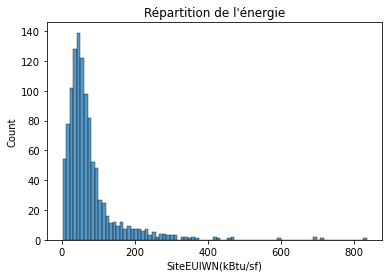

In [9]:
sns.histplot(df['SiteEUIWN(kBtu/sf)'])
plt.title('Répartition de l\'énergie');

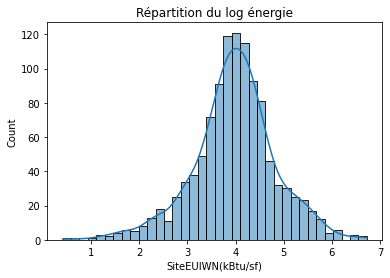

In [10]:
sns.histplot(np.log(df['SiteEUIWN(kBtu/sf)']),kde=True)
plt.title('Répartition du log énergie');

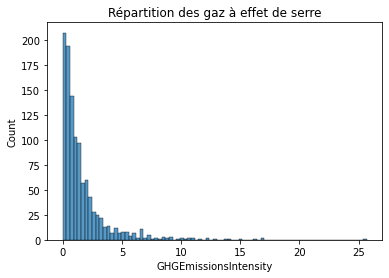

In [11]:
sns.histplot(df['GHGEmissionsIntensity'])
plt.title('Répartition des gaz à effet de serre');

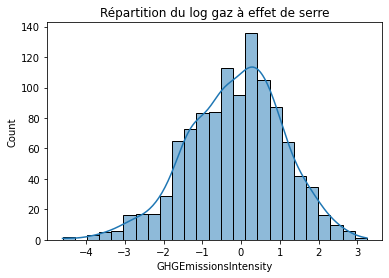

In [12]:
sns.histplot(np.log(df['GHGEmissionsIntensity']),kde=True)
plt.title('Répartition du log gaz à effet de serre');

In [13]:
df['SiteEUIWN(kBtu/sf)'] = np.log(df['SiteEUIWN(kBtu/sf)'])
df['GHGEmissionsIntensity'] = np.log(df['GHGEmissionsIntensity'])

In [14]:
df.isnull().sum()

BuildingType                       0
PrimaryPropertyType                0
Neighborhood                       0
Latitude                           0
Longitude                          0
NumberofBuildings                  0
NumberofFloors                     0
PropertyGFATotal                   0
PropertyGFAParking                 0
PropertyGFABuilding(s)             0
LargestPropertyUseTypeGFA          0
SecondLargestPropertyUseTypeGFA    0
ThirdLargestPropertyUseTypeGFA     0
ENERGYSTARScore                    0
SiteEUIWN(kBtu/sf)                 0
SteamUse(kBtu)                     0
NaturalGas(kBtu)                   0
GHGEmissionsIntensity              1
AgeRangeBuilt                      0
ParkingGFARate                     0
BuildingGFARate                    0
GFAPerFloor                        0
dtype: int64

In [15]:
df.drop(df[df['GHGEmissionsIntensity'].isna()].index,inplace=True)

In [16]:
df.isnull().sum()

BuildingType                       0
PrimaryPropertyType                0
Neighborhood                       0
Latitude                           0
Longitude                          0
NumberofBuildings                  0
NumberofFloors                     0
PropertyGFATotal                   0
PropertyGFAParking                 0
PropertyGFABuilding(s)             0
LargestPropertyUseTypeGFA          0
SecondLargestPropertyUseTypeGFA    0
ThirdLargestPropertyUseTypeGFA     0
ENERGYSTARScore                    0
SiteEUIWN(kBtu/sf)                 0
SteamUse(kBtu)                     0
NaturalGas(kBtu)                   0
GHGEmissionsIntensity              0
AgeRangeBuilt                      0
ParkingGFARate                     0
BuildingGFARate                    0
GFAPerFloor                        0
dtype: int64

In [17]:
df.head()

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity,AgeRangeBuilt,ParkingGFARate,BuildingGFARate,GFAPerFloor
0,NonResidential,Hotel,DOWNTOWN,47.61220,-122.33799,1.0,12,88434,0,88434,88434.0,0.0,0.0,60.0,4.434382,2003882.00,1276453.0,1.040277,"(90, 100]",0.000000,1.000000,6802.615385
1,NonResidential,Hotel,DOWNTOWN,47.61317,-122.33393,1.0,11,103566,15064,88502,83880.0,15064.0,4622.0,61.0,4.583947,0.00,5145082.0,1.050822,"(20, 30]",0.145453,0.854547,7375.166667
2,NonResidential,Hotel,DOWNTOWN,47.61412,-122.33664,1.0,10,61320,0,61320,61320.0,0.0,0.0,56.0,4.730039,2214446.25,1811213.0,1.541159,"(90, 100]",0.000000,1.000000,5574.545455
3,NonResidential,Hotel,DOWNTOWN,47.61375,-122.34047,1.0,18,175580,62000,113580,123445.0,68009.0,0.0,75.0,4.776599,0.00,8803998.0,1.057790,"(40, 50]",0.353115,0.646885,5977.894737
4,Nonresidential COS,Other,DOWNTOWN,47.61623,-122.33657,1.0,2,97288,37198,60090,88830.0,0.0,0.0,79.8,4.953006,0.00,4715182.0,1.131402,"(20, 30]",0.382349,0.617651,20030.000000


In [18]:
ohe = OneHotEncoder()
feature_array = ohe.fit_transform(df[['BuildingType','Neighborhood','AgeRangeBuilt','PrimaryPropertyType']]).toarray()
ohe.get_feature_names()

array(['x0_Campus', 'x0_NonResidential', 'x0_Nonresidential COS',
       'x0_Nonresidential WA', 'x0_SPS-District K-12', 'x1_BALLARD',
       'x1_Ballard', 'x1_CENTRAL', 'x1_Central', 'x1_DELRIDGE',
       'x1_DOWNTOWN', 'x1_Delridge', 'x1_EAST', 'x1_GREATER DUWAMISH',
       'x1_LAKE UNION', 'x1_MAGNOLIA / QUEEN ANNE', 'x1_NORTH',
       'x1_NORTHEAST', 'x1_NORTHWEST', 'x1_North', 'x1_Northwest',
       'x1_SOUTHEAST', 'x1_SOUTHWEST', 'x2_(0, 10]', 'x2_(10, 20]',
       'x2_(100, 110]', 'x2_(110, 120]', 'x2_(120, 130]', 'x2_(20, 30]',
       'x2_(30, 40]', 'x2_(40, 50]', 'x2_(50, 60]', 'x2_(60, 70]',
       'x2_(70, 80]', 'x2_(80, 90]', 'x2_(90, 100]',
       'x3_Distribution Center', 'x3_Hospital', 'x3_Hotel',
       'x3_K-12 School', 'x3_Laboratory', 'x3_Large Office',
       'x3_Medical Office', 'x3_Mixed Use Property', 'x3_Other',
       'x3_Refrigerated Warehouse', 'x3_Residence Hall', 'x3_Restaurant',
       'x3_Retail Store', 'x3_Self-Storage Facility',
       'x3_Senior Care C

In [19]:
feature_labels = ['x0_Campus', 'x0_NonResidential', 'x0_Nonresidential COS',
       'x0_Nonresidential WA', 'x0_SPS-District K-12', 'x1_BALLARD',
       'x1_Ballard', 'x1_CENTRAL', 'x1_Central', 'x1_DELRIDGE',
       'x1_DOWNTOWN', 'x1_Delridge', 'x1_EAST', 'x1_GREATER DUWAMISH',
       'x1_LAKE UNION', 'x1_MAGNOLIA / QUEEN ANNE', 'x1_NORTH',
       'x1_NORTHEAST', 'x1_NORTHWEST', 'x1_North', 'x1_Northwest',
       'x1_SOUTHEAST', 'x1_SOUTHWEST', 'x2_(0, 10]', 'x2_(10, 20]',
       'x2_(100, 110]', 'x2_(110, 120]', 'x2_(120, 130]', 'x2_(20, 30]',
       'x2_(30, 40]', 'x2_(40, 50]', 'x2_(50, 60]', 'x2_(60, 70]',
       'x2_(70, 80]', 'x2_(80, 90]', 'x2_(90, 100]',
       'x3_Distribution Center', 'x3_Hospital', 'x3_Hotel',
       'x3_K-12 School', 'x3_Laboratory', 'x3_Large Office',
       'x3_Medical Office', 'x3_Mixed Use Property', 'x3_Other',
       'x3_Refrigerated Warehouse', 'x3_Residence Hall', 'x3_Restaurant',
       'x3_Retail Store', 'x3_Self-Storage Facility',
       'x3_Senior Care Community', 'x3_Small- and Mid-Sized Office',
       'x3_Supermarket / Grocery Store', 'x3_University', 'x3_Warehouse',
       'x3_Worship Facility']

In [20]:
features = pd.DataFrame(feature_array,columns = feature_labels)

In [21]:
data = pd.concat([df,features],axis=1)
data.head()

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity,AgeRangeBuilt,ParkingGFARate,BuildingGFARate,GFAPerFloor,x0_Campus,x0_NonResidential,x0_Nonresidential COS,x0_Nonresidential WA,x0_SPS-District K-12,x1_BALLARD,x1_Ballard,x1_CENTRAL,x1_Central,x1_DELRIDGE,x1_DOWNTOWN,x1_Delridge,x1_EAST,x1_GREATER DUWAMISH,x1_LAKE UNION,x1_MAGNOLIA / QUEEN ANNE,x1_NORTH,x1_NORTHEAST,x1_NORTHWEST,x1_North,x1_Northwest,x1_SOUTHEAST,x1_SOUTHWEST,"x2_(0, 10]","x2_(10, 20]","x2_(100, 110]","x2_(110, 120]","x2_(120, 130]","x2_(20, 30]","x2_(30, 40]","x2_(40, 50]","x2_(50, 60]","x2_(60, 70]","x2_(70, 80]","x2_(80, 90]","x2_(90, 100]",x3_Distribution Center,x3_Hospital,x3_Hotel,x3_K-12 School,x3_Laboratory,x3_Large Office,x3_Medical Office,x3_Mixed Use Property,x3_Other,x3_Refrigerated Warehouse,x3_Residence Hall,x3_Restaurant,x3_Retail Store,x3_Self-Storage Facility,x3_Senior Care Community,x3_Small- and Mid-Sized Office,x3_Supermarket / Grocery Store,x3_University,x3_Warehouse,x3_Worship Facility
0,NonResidential,Hotel,DOWNTOWN,47.61220,-122.33799,1.0,12.0,88434.0,0.0,88434.0,88434.0,0.0,0.0,60.0,4.434382,2003882.00,1276453.0,1.040277,"(90, 100]",0.000000,1.000000,6802.615385,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NonResidential,Hotel,DOWNTOWN,47.61317,-122.33393,1.0,11.0,103566.0,15064.0,88502.0,83880.0,15064.0,4622.0,61.0,4.583947,0.00,5145082.0,1.050822,"(20, 30]",0.145453,0.854547,7375.166667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NonResidential,Hotel,DOWNTOWN,47.61412,-122.33664,1.0,10.0,61320.0,0.0,61320.0,61320.0,0.0,0.0,56.0,4.730039,2214446.25,1811213.0,1.541159,"(90, 100]",0.000000,1.000000,5574.545455,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NonResidential,Hotel,DOWNTOWN,47.61375,-122.34047,1.0,18.0,175580.0,62000.0,113580.0,123445.0,68009.0,0.0,75.0,4.776599,0.00,8803998.0,1.057790,"(40, 50]",0.353115,0.646885,5977.894737,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Nonresidential COS,Other,DOWNTOWN,47.61623,-122.33657,1.0,2.0,97288.0,37198.0,60090.0,88830.0,0.0,0.0,79.8,4.953006,0.00,4715182.0,1.131402,"(20, 30]",0.382349,0.617651,20030.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
#suppression des variables utilisées
data.drop(columns=['BuildingType','Neighborhood','AgeRangeBuilt','PrimaryPropertyType'],inplace=True)

In [23]:
data.head()

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity,ParkingGFARate,BuildingGFARate,GFAPerFloor,x0_Campus,x0_NonResidential,x0_Nonresidential COS,x0_Nonresidential WA,x0_SPS-District K-12,x1_BALLARD,x1_Ballard,x1_CENTRAL,x1_Central,x1_DELRIDGE,x1_DOWNTOWN,x1_Delridge,x1_EAST,x1_GREATER DUWAMISH,x1_LAKE UNION,x1_MAGNOLIA / QUEEN ANNE,x1_NORTH,x1_NORTHEAST,x1_NORTHWEST,x1_North,x1_Northwest,x1_SOUTHEAST,x1_SOUTHWEST,"x2_(0, 10]","x2_(10, 20]","x2_(100, 110]","x2_(110, 120]","x2_(120, 130]","x2_(20, 30]","x2_(30, 40]","x2_(40, 50]","x2_(50, 60]","x2_(60, 70]","x2_(70, 80]","x2_(80, 90]","x2_(90, 100]",x3_Distribution Center,x3_Hospital,x3_Hotel,x3_K-12 School,x3_Laboratory,x3_Large Office,x3_Medical Office,x3_Mixed Use Property,x3_Other,x3_Refrigerated Warehouse,x3_Residence Hall,x3_Restaurant,x3_Retail Store,x3_Self-Storage Facility,x3_Senior Care Community,x3_Small- and Mid-Sized Office,x3_Supermarket / Grocery Store,x3_University,x3_Warehouse,x3_Worship Facility
0,47.61220,-122.33799,1.0,12.0,88434.0,0.0,88434.0,88434.0,0.0,0.0,60.0,4.434382,2003882.00,1276453.0,1.040277,0.000000,1.000000,6802.615385,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,47.61317,-122.33393,1.0,11.0,103566.0,15064.0,88502.0,83880.0,15064.0,4622.0,61.0,4.583947,0.00,5145082.0,1.050822,0.145453,0.854547,7375.166667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,47.61412,-122.33664,1.0,10.0,61320.0,0.0,61320.0,61320.0,0.0,0.0,56.0,4.730039,2214446.25,1811213.0,1.541159,0.000000,1.000000,5574.545455,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,47.61375,-122.34047,1.0,18.0,175580.0,62000.0,113580.0,123445.0,68009.0,0.0,75.0,4.776599,0.00,8803998.0,1.057790,0.353115,0.646885,5977.894737,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,47.61623,-122.33657,1.0,2.0,97288.0,37198.0,60090.0,88830.0,0.0,0.0,79.8,4.953006,0.00,4715182.0,1.131402,0.382349,0.617651,20030.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
ss = StandardScaler()
data.columns

Index(['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEUIWN(kBtu/sf)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)',
       'GHGEmissionsIntensity', 'ParkingGFARate', 'BuildingGFARate',
       'GFAPerFloor', 'x0_Campus', 'x0_NonResidential',
       'x0_Nonresidential COS', 'x0_Nonresidential WA', 'x0_SPS-District K-12',
       'x1_BALLARD', 'x1_Ballard', 'x1_CENTRAL', 'x1_Central', 'x1_DELRIDGE',
       'x1_DOWNTOWN', 'x1_Delridge', 'x1_EAST', 'x1_GREATER DUWAMISH',
       'x1_LAKE UNION', 'x1_MAGNOLIA / QUEEN ANNE', 'x1_NORTH', 'x1_NORTHEAST',
       'x1_NORTHWEST', 'x1_North', 'x1_Northwest', 'x1_SOUTHEAST',
       'x1_SOUTHWEST', 'x2_(0, 10]', 'x2_(10, 20]', 'x2_(100, 110]',
       'x2_(110, 120]', 'x2_(120, 130]', 'x2_(20, 30]', 'x2_(30, 40]',
       'x2_(40,

In [25]:
numerical_columns = ['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEUIWN(kBtu/sf)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)',
       'GHGEmissionsIntensity', 'ParkingGFARate', 'BuildingGFARate',
       'GFAPerFloor', 'x0_Campus', 'x0_NonResidential',
       'x0_Nonresidential COS', 'x0_Nonresidential WA', 'x0_SPS-District K-12',
       'x1_BALLARD', 'x1_Ballard', 'x1_CENTRAL', 'x1_Central', 'x1_DELRIDGE',
       'x1_DOWNTOWN', 'x1_Delridge', 'x1_EAST', 'x1_GREATER DUWAMISH',
       'x1_LAKE UNION', 'x1_MAGNOLIA / QUEEN ANNE', 'x1_NORTH', 'x1_NORTHEAST',
       'x1_NORTHWEST', 'x1_North', 'x1_Northwest', 'x1_SOUTHEAST',
       'x1_SOUTHWEST', 'x2_(0, 10]', 'x2_(10, 20]', 'x2_(100, 110]',
       'x2_(110, 120]', 'x2_(120, 130]', 'x2_(20, 30]', 'x2_(30, 40]',
       'x2_(40, 50]', 'x2_(50, 60]', 'x2_(60, 70]', 'x2_(70, 80]',
       'x2_(80, 90]', 'x2_(90, 100]', 'x3_Distribution Center', 'x3_Hospital',
       'x3_Hotel', 'x3_K-12 School', 'x3_Laboratory', 'x3_Large Office',
       'x3_Medical Office', 'x3_Mixed Use Property', 'x3_Other',
       'x3_Refrigerated Warehouse', 'x3_Residence Hall', 'x3_Restaurant',
       'x3_Retail Store', 'x3_Self-Storage Facility',
       'x3_Senior Care Community', 'x3_Small- and Mid-Sized Office',
       'x3_Supermarket / Grocery Store', 'x3_University', 'x3_Warehouse',
       'x3_Worship Facility']

In [26]:
data[numerical_columns] = ss.fit_transform(data[numerical_columns])
data.head()

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity,ParkingGFARate,BuildingGFARate,GFAPerFloor,x0_Campus,x0_NonResidential,x0_Nonresidential COS,x0_Nonresidential WA,x0_SPS-District K-12,x1_BALLARD,x1_Ballard,x1_CENTRAL,x1_Central,x1_DELRIDGE,x1_DOWNTOWN,x1_Delridge,x1_EAST,x1_GREATER DUWAMISH,x1_LAKE UNION,x1_MAGNOLIA / QUEEN ANNE,x1_NORTH,x1_NORTHEAST,x1_NORTHWEST,x1_North,x1_Northwest,x1_SOUTHEAST,x1_SOUTHWEST,"x2_(0, 10]","x2_(10, 20]","x2_(100, 110]","x2_(110, 120]","x2_(120, 130]","x2_(20, 30]","x2_(30, 40]","x2_(40, 50]","x2_(50, 60]","x2_(60, 70]","x2_(70, 80]","x2_(80, 90]","x2_(90, 100]",x3_Distribution Center,x3_Hospital,x3_Hotel,x3_K-12 School,x3_Laboratory,x3_Large Office,x3_Medical Office,x3_Mixed Use Property,x3_Other,x3_Refrigerated Warehouse,x3_Residence Hall,x3_Restaurant,x3_Retail Store,x3_Self-Storage Facility,x3_Senior Care Community,x3_Small- and Mid-Sized Office,x3_Supermarket / Grocery Store,x3_University,x3_Warehouse,x3_Worship Facility
0,-0.078502,-0.177848,-0.117648,2.458712,0.445834,-0.258357,0.645761,0.644239,-0.488577,-0.260372,-0.056251,0.538480,3.870904,-0.035666,0.977701,-0.375267,0.375267,-0.762617,-0.117041,0.278693,-0.234804,-0.030029,-0.073721,-0.214902,-0.060138,-0.185695,-0.052058,-0.1695,2.221673,-0.052058,-0.26141,-0.579431,-0.300621,-0.33666,-0.190826,-0.286132,-0.2453,-0.079664,-0.052058,-0.145462,-0.142199,-0.128388,-0.259437,-0.26141,-0.28797,-0.180439,-0.314658,-0.305935,-0.359439,-0.389169,-0.398326,-0.255459,-0.157895,2.927280,-0.207926,-0.042486,4.510671,-0.183083,-0.073721,-0.214902,-0.120935,-0.239046,-0.453003,-0.100045,-0.120935,-0.100045,-0.253452,-0.154872,-0.113021,-0.518239,-0.1695,-0.128388,-0.417855,-0.239046
1,-0.059164,-0.012695,-0.117648,2.190145,0.685955,0.360832,0.647038,0.564812,0.476321,0.802367,-0.015086,0.715234,-0.148197,0.647870,0.986340,0.745913,-0.745913,-0.709218,-0.117041,0.278693,-0.234804,-0.030029,-0.073721,-0.214902,-0.060138,-0.185695,-0.052058,-0.1695,2.221673,-0.052058,-0.26141,-0.579431,-0.300621,-0.33666,-0.190826,-0.286132,-0.2453,-0.079664,-0.052058,-0.145462,-0.142199,-0.128388,-0.259437,-0.26141,-0.28797,-0.180439,3.178050,-0.305935,-0.359439,-0.389169,-0.398326,-0.255459,-0.157895,-0.341614,-0.207926,-0.042486,4.510671,-0.183083,-0.073721,-0.214902,-0.120935,-0.239046,-0.453003,-0.100045,-0.120935,-0.100045,-0.253452,-0.154872,-0.113021,-0.518239,-0.1695,-0.128388,-0.417855,-0.239046
2,-0.040224,-0.122932,-0.117648,1.921579,0.015578,-0.258357,0.136495,0.171341,-0.488577,-0.260372,-0.220912,0.887885,4.293224,0.058819,1.388065,-0.375267,0.375267,-0.877153,-0.117041,0.278693,-0.234804,-0.030029,-0.073721,-0.214902,-0.060138,-0.185695,-0.052058,-0.1695,2.221673,-0.052058,-0.26141,-0.579431,-0.300621,-0.33666,-0.190826,-0.286132,-0.2453,-0.079664,-0.052058,-0.145462,-0.142199,-0.128388,-0.259437,-0.26141,-0.28797,-0.180439,-0.314658,-0.305935,-0.359439,-0.389169,-0.398326,-0.255459,-0.157895,2.927280,-0.207926,-0.042486,4.510671,-0.183083,-0.073721,-0.214902,-0.120935,-0.239046,-0.453003,-0.100045,-0.120935,-0.100045,-0.253452,-0.154872,-0.113021,-0.518239,-0.1695,-0.128388,-0.417855,-0.239046
3,-0.047601,-0.278729,-0.117648,4.070109,1.828702,2.290081,1.118063,1.254870,3.867620,-0.260372,0.561224,0.942909,-0.148197,1.294354,0.992049,2.346612,-2.346612,-0.839535,-0.117041,0.278693,-0.234804,-0.030029,-0.073721,-0.214902,-0.060138,-0.185695,-0.052058,-0.1695,2.221673,-0.052058,-0.26141,-0.579431,-0.300621,-0.33666,-0.190826,-0.286132,-0.2453,-0.079664,-0.052058,-0.145462,-0.142199,-0.128388,-0.259437,-0.26141,-0.28797,-0.180439,-0.314658,-0.305935,2.782114,-0.389169,-0.398326,-0.255459,-0.157895,-0.341614,-0.207926,-0.042486,4.510671,-0.183083,-0.073721,-0.214902,-0.120935,-0.239046,-0.453003,-0.100045,-0.120935,-

In [27]:
data.isnull().sum()

Latitude                           1
Longitude                          1
NumberofBuildings                  1
NumberofFloors                     1
PropertyGFATotal                   1
PropertyGFAParking                 1
PropertyGFABuilding(s)             1
LargestPropertyUseTypeGFA          1
SecondLargestPropertyUseTypeGFA    1
ThirdLargestPropertyUseTypeGFA     1
ENERGYSTARScore                    1
SiteEUIWN(kBtu/sf)                 1
SteamUse(kBtu)                     1
NaturalGas(kBtu)                   1
GHGEmissionsIntensity              1
ParkingGFARate                     1
BuildingGFARate                    1
GFAPerFloor                        1
x0_Campus                          1
x0_NonResidential                  1
x0_Nonresidential COS              1
x0_Nonresidential WA               1
x0_SPS-District K-12               1
x1_BALLARD                         1
x1_Ballard                         1
x1_CENTRAL                         1
x1_Central                         1
x

In [28]:
data.drop(data[data['NumberofBuildings'].isna()].index,inplace=True)
data.drop(data[data['x1_BALLARD'].isna()].index,inplace=True)

In [29]:
data.isnull().sum()

Latitude                           0
Longitude                          0
NumberofBuildings                  0
NumberofFloors                     0
PropertyGFATotal                   0
PropertyGFAParking                 0
PropertyGFABuilding(s)             0
LargestPropertyUseTypeGFA          0
SecondLargestPropertyUseTypeGFA    0
ThirdLargestPropertyUseTypeGFA     0
ENERGYSTARScore                    0
SiteEUIWN(kBtu/sf)                 0
SteamUse(kBtu)                     0
NaturalGas(kBtu)                   0
GHGEmissionsIntensity              0
ParkingGFARate                     0
BuildingGFARate                    0
GFAPerFloor                        0
x0_Campus                          0
x0_NonResidential                  0
x0_Nonresidential COS              0
x0_Nonresidential WA               0
x0_SPS-District K-12               0
x1_BALLARD                         0
x1_Ballard                         0
x1_CENTRAL                         0
x1_Central                         0
x

In [30]:
data_gaz = data.copy()
data_gaz.drop(columns=['SiteEUIWN(kBtu/sf)'],inplace=True)
data_gaz.head()

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SteamUse(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity,ParkingGFARate,BuildingGFARate,GFAPerFloor,x0_Campus,x0_NonResidential,x0_Nonresidential COS,x0_Nonresidential WA,x0_SPS-District K-12,x1_BALLARD,x1_Ballard,x1_CENTRAL,x1_Central,x1_DELRIDGE,x1_DOWNTOWN,x1_Delridge,x1_EAST,x1_GREATER DUWAMISH,x1_LAKE UNION,x1_MAGNOLIA / QUEEN ANNE,x1_NORTH,x1_NORTHEAST,x1_NORTHWEST,x1_North,x1_Northwest,x1_SOUTHEAST,x1_SOUTHWEST,"x2_(0, 10]","x2_(10, 20]","x2_(100, 110]","x2_(110, 120]","x2_(120, 130]","x2_(20, 30]","x2_(30, 40]","x2_(40, 50]","x2_(50, 60]","x2_(60, 70]","x2_(70, 80]","x2_(80, 90]","x2_(90, 100]",x3_Distribution Center,x3_Hospital,x3_Hotel,x3_K-12 School,x3_Laboratory,x3_Large Office,x3_Medical Office,x3_Mixed Use Property,x3_Other,x3_Refrigerated Warehouse,x3_Residence Hall,x3_Restaurant,x3_Retail Store,x3_Self-Storage Facility,x3_Senior Care Community,x3_Small- and Mid-Sized Office,x3_Supermarket / Grocery Store,x3_University,x3_Warehouse,x3_Worship Facility
0,-0.078502,-0.177848,-0.117648,2.458712,0.445834,-0.258357,0.645761,0.644239,-0.488577,-0.260372,-0.056251,3.870904,-0.035666,0.977701,-0.375267,0.375267,-0.762617,-0.117041,0.278693,-0.234804,-0.030029,-0.073721,-0.214902,-0.060138,-0.185695,-0.052058,-0.1695,2.221673,-0.052058,-0.26141,-0.579431,-0.300621,-0.33666,-0.190826,-0.286132,-0.2453,-0.079664,-0.052058,-0.145462,-0.142199,-0.128388,-0.259437,-0.26141,-0.28797,-0.180439,-0.314658,-0.305935,-0.359439,-0.389169,-0.398326,-0.255459,-0.157895,2.927280,-0.207926,-0.042486,4.510671,-0.183083,-0.073721,-0.214902,-0.120935,-0.239046,-0.453003,-0.100045,-0.120935,-0.100045,-0.253452,-0.154872,-0.113021,-0.518239,-0.1695,-0.128388,-0.417855,-0.239046
1,-0.059164,-0.012695,-0.117648,2.190145,0.685955,0.360832,0.647038,0.564812,0.476321,0.802367,-0.015086,-0.148197,0.647870,0.986340,0.745913,-0.745913,-0.709218,-0.117041,0.278693,-0.234804,-0.030029,-0.073721,-0.214902,-0.060138,-0.185695,-0.052058,-0.1695,2.221673,-0.052058,-0.26141,-0.579431,-0.300621,-0.33666,-0.190826,-0.286132,-0.2453,-0.079664,-0.052058,-0.145462,-0.142199,-0.128388,-0.259437,-0.26141,-0.28797,-0.180439,3.178050,-0.305935,-0.359439,-0.389169,-0.398326,-0.255459,-0.157895,-0.341614,-0.207926,-0.042486,4.510671,-0.183083,-0.073721,-0.214902,-0.120935,-0.239046,-0.453003,-0.100045,-0.120935,-0.100045,-0.253452,-0.154872,-0.113021,-0.518239,-0.1695,-0.128388,-0.417855,-0.239046
2,-0.040224,-0.122932,-0.117648,1.921579,0.015578,-0.258357,0.136495,0.171341,-0.488577,-0.260372,-0.220912,4.293224,0.058819,1.388065,-0.375267,0.375267,-0.877153,-0.117041,0.278693,-0.234804,-0.030029,-0.073721,-0.214902,-0.060138,-0.185695,-0.052058,-0.1695,2.221673,-0.052058,-0.26141,-0.579431,-0.300621,-0.33666,-0.190826,-0.286132,-0.2453,-0.079664,-0.052058,-0.145462,-0.142199,-0.128388,-0.259437,-0.26141,-0.28797,-0.180439,-0.314658,-0.305935,-0.359439,-0.389169,-0.398326,-0.255459,-0.157895,2.927280,-0.207926,-0.042486,4.510671,-0.183083,-0.073721,-0.214902,-0.120935,-0.239046,-0.453003,-0.100045,-0.120935,-0.100045,-0.253452,-0.154872,-0.113021,-0.518239,-0.1695,-0.128388,-0.417855,-0.239046
3,-0.047601,-0.278729,-0.117648,4.070109,1.828702,2.290081,1.118063,1.254870,3.867620,-0.260372,0.561224,-0.148197,1.294354,0.992049,2.346612,-2.346612,-0.839535,-0.117041,0.278693,-0.234804,-0.030029,-0.073721,-0.214902,-0.060138,-0.185695,-0.052058,-0.1695,2.221673,-0.052058,-0.26141,-0.579431,-0.300621,-0.33666,-0.190826,-0.286132,-0.2453,-0.079664,-0.052058,-0.145462,-0.142199,-0.128388,-0.259437,-0.26141,-0.28797,-0.180439,-0.314658,-0.305935,2.782114,-0.389169,-0.398326,-0.255459,-0.157895,-0.341614,-0.207926,-0.042486,4.510671,-0.183083,-0.073721,-0.214902,-0.120935,-0.239046,-0.453003,-0.100045,-0.120935,-0.100045,-0.253452,-0.154872,-0.113021,-0.518239,-0.169

In [31]:
data_gaz_without_energyscore = data_gaz.copy()
data_gaz_without_energyscore.drop(columns=['ENERGYSTARScore'],inplace=True)
data_gaz_without_energyscore.head()

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SteamUse(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity,ParkingGFARate,BuildingGFARate,GFAPerFloor,x0_Campus,x0_NonResidential,x0_Nonresidential COS,x0_Nonresidential WA,x0_SPS-District K-12,x1_BALLARD,x1_Ballard,x1_CENTRAL,x1_Central,x1_DELRIDGE,x1_DOWNTOWN,x1_Delridge,x1_EAST,x1_GREATER DUWAMISH,x1_LAKE UNION,x1_MAGNOLIA / QUEEN ANNE,x1_NORTH,x1_NORTHEAST,x1_NORTHWEST,x1_North,x1_Northwest,x1_SOUTHEAST,x1_SOUTHWEST,"x2_(0, 10]","x2_(10, 20]","x2_(100, 110]","x2_(110, 120]","x2_(120, 130]","x2_(20, 30]","x2_(30, 40]","x2_(40, 50]","x2_(50, 60]","x2_(60, 70]","x2_(70, 80]","x2_(80, 90]","x2_(90, 100]",x3_Distribution Center,x3_Hospital,x3_Hotel,x3_K-12 School,x3_Laboratory,x3_Large Office,x3_Medical Office,x3_Mixed Use Property,x3_Other,x3_Refrigerated Warehouse,x3_Residence Hall,x3_Restaurant,x3_Retail Store,x3_Self-Storage Facility,x3_Senior Care Community,x3_Small- and Mid-Sized Office,x3_Supermarket / Grocery Store,x3_University,x3_Warehouse,x3_Worship Facility
0,-0.078502,-0.177848,-0.117648,2.458712,0.445834,-0.258357,0.645761,0.644239,-0.488577,-0.260372,3.870904,-0.035666,0.977701,-0.375267,0.375267,-0.762617,-0.117041,0.278693,-0.234804,-0.030029,-0.073721,-0.214902,-0.060138,-0.185695,-0.052058,-0.1695,2.221673,-0.052058,-0.26141,-0.579431,-0.300621,-0.33666,-0.190826,-0.286132,-0.2453,-0.079664,-0.052058,-0.145462,-0.142199,-0.128388,-0.259437,-0.26141,-0.28797,-0.180439,-0.314658,-0.305935,-0.359439,-0.389169,-0.398326,-0.255459,-0.157895,2.927280,-0.207926,-0.042486,4.510671,-0.183083,-0.073721,-0.214902,-0.120935,-0.239046,-0.453003,-0.100045,-0.120935,-0.100045,-0.253452,-0.154872,-0.113021,-0.518239,-0.1695,-0.128388,-0.417855,-0.239046
1,-0.059164,-0.012695,-0.117648,2.190145,0.685955,0.360832,0.647038,0.564812,0.476321,0.802367,-0.148197,0.647870,0.986340,0.745913,-0.745913,-0.709218,-0.117041,0.278693,-0.234804,-0.030029,-0.073721,-0.214902,-0.060138,-0.185695,-0.052058,-0.1695,2.221673,-0.052058,-0.26141,-0.579431,-0.300621,-0.33666,-0.190826,-0.286132,-0.2453,-0.079664,-0.052058,-0.145462,-0.142199,-0.128388,-0.259437,-0.26141,-0.28797,-0.180439,3.178050,-0.305935,-0.359439,-0.389169,-0.398326,-0.255459,-0.157895,-0.341614,-0.207926,-0.042486,4.510671,-0.183083,-0.073721,-0.214902,-0.120935,-0.239046,-0.453003,-0.100045,-0.120935,-0.100045,-0.253452,-0.154872,-0.113021,-0.518239,-0.1695,-0.128388,-0.417855,-0.239046
2,-0.040224,-0.122932,-0.117648,1.921579,0.015578,-0.258357,0.136495,0.171341,-0.488577,-0.260372,4.293224,0.058819,1.388065,-0.375267,0.375267,-0.877153,-0.117041,0.278693,-0.234804,-0.030029,-0.073721,-0.214902,-0.060138,-0.185695,-0.052058,-0.1695,2.221673,-0.052058,-0.26141,-0.579431,-0.300621,-0.33666,-0.190826,-0.286132,-0.2453,-0.079664,-0.052058,-0.145462,-0.142199,-0.128388,-0.259437,-0.26141,-0.28797,-0.180439,-0.314658,-0.305935,-0.359439,-0.389169,-0.398326,-0.255459,-0.157895,2.927280,-0.207926,-0.042486,4.510671,-0.183083,-0.073721,-0.214902,-0.120935,-0.239046,-0.453003,-0.100045,-0.120935,-0.100045,-0.253452,-0.154872,-0.113021,-0.518239,-0.1695,-0.128388,-0.417855,-0.239046
3,-0.047601,-0.278729,-0.117648,4.070109,1.828702,2.290081,1.118063,1.254870,3.867620,-0.260372,-0.148197,1.294354,0.992049,2.346612,-2.346612,-0.839535,-0.117041,0.278693,-0.234804,-0.030029,-0.073721,-0.214902,-0.060138,-0.185695,-0.052058,-0.1695,2.221673,-0.052058,-0.26141,-0.579431,-0.300621,-0.33666,-0.190826,-0.286132,-0.2453,-0.079664,-0.052058,-0.145462,-0.142199,-0.128388,-0.259437,-0.26141,-0.28797,-0.180439,-0.314658,-0.305935,2.782114,-0.389169,-0.398326,-0.255459,-0.157895,-0.341614,-0.207926,-0.042486,4.510671,-0.183083,-0.073721,-0.214902,-0.120935,-0.239046,-0.453003,-0.100045,-0.120935,-0.100045,-0.253452,-0.154872,-0.113021,-0.518239,-0.1695,-0.128388,-0.417855,-0.239046
4,0.001841,-0.120085,-0

In [32]:
#modèles linéaires

#paramètres pour SGDRegressor
params_sgd = {
    'alpha': [0.0001, 0.001, 0.01, 0.01, 1, 10, 100],
    'penalty': ['l2','l1','elasticnet', None],
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'learning_rate': ['constant', 'optimal', 'invscaling']
}

#paramètres pour Elasticnet (L1 ratio , =1 équivaut à un Lasso, 0 à un Ridge)
params_elasticnet = {
     'tol' : [0.1,0.01,0.001,0.0001],
     'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  
     'l1_ratio': np.arange(0.0, 1.0, 0.1)
                    }


#modèles non-linéaires

#paramètres RandomForestRegressor
params_random_forest = {
    'max_features' : ['sqrt','log2'],
    'max_depth' : [5, 15, 25 ,50],
    'min_samples_split' : [2, 5, 10],
    'bootstrap' : [True, False],
    'min_samples_leaf' : [1, 2, 5, 10]
}

#paramètres AdaBoostRegressor
param_grid_adaboost = [{
    "n_estimators": [50, 100], 
    "learning_rate": [0.001,0.01,0.1,1,10],
    "loss": ['linear', 'square', 'exponential']
}]

In [33]:
def estimation(params,model,X_train,X_test,y_train,y_test,X,y):
    grid =GridSearchCV(estimator = model(random_state=0),
                 param_grid = params,
                 return_train_score = True,
                 scoring='r2',
                 cv=5)
    
    grid.fit(X_train,y_train)
    
    model_estimator = grid.best_estimator_
    
    y_pred = grid.best_estimator_.predict(X)
    
    res = grid.cv_results_
    res = pd.DataFrame(res)
    cols = [ i for i in res.columns if 'split' not in i]
    res = res[cols]
    res = res.sort_values('rank_test_score')
    display(res.head())
    
    print("Best params : " , grid.best_params_)
    best_params = grid.best_params_
    estimator = model(**best_params,random_state=0)
    estimator.fit(X_train,y_train)
    
    tr_score = estimator.score(X_train,y_train)
    te_score = estimator.score(X_test,y_test)
    print(f"score train : {tr_score} score test : {te_score}")
    
    print("RMSE : " + str(mean_squared_error(y,y_pred)))
    print("MAE : " + str(mean_absolute_error(y,y_pred)))
    print('median abs err ' + str(median_absolute_error(y,y_pred)))
    
    rmse = mean_squared_error(y,y_pred)
    mae = mean_absolute_error(y,y_pred)
    median = median_absolute_error(y,y_pred)
    
    err_hist = np.abs(y - y_pred)
    plt.hist(err_hist,bins=50)
    plt.title('Erreurs entre valeurs réelles et valeurs prédites')
    plt.show()
    
    N,train_score, val_score =learning_curve(model_estimator, X_train, y_train, train_sizes = np.linspace(0.2,1.0,5),cv=5)

    plt.plot(N,train_score.mean(axis=1),label='train')
    plt.plot(N,val_score.mean(axis=1),label='validation')
    plt.xlabel('train_sizes')
    plt.legend()
    plt.show()

    return te_score, rmse, mae, median


In [34]:
def estimation_importances(params,model,X_train,X_test,y_train,y_test,X,y):
    grid =GridSearchCV(estimator = model(random_state=0),
                 param_grid = params,
                 return_train_score = True,
                 scoring='r2',
                 cv=5)
    
    grid.fit(X_train,y_train)
    
    model_estimator = grid.best_estimator_
    
    y_pred = grid.best_estimator_.predict(X)
    
    res = grid.cv_results_
    res = pd.DataFrame(res)
    cols = [ i for i in res.columns if 'split' not in i]
    res = res[cols]
    res = res.sort_values('rank_test_score')
    display(res.head())
    
    print("Best params : " , grid.best_params_)
    best_params = grid.best_params_
    estimator = model(**best_params,random_state=0)
    estimator.fit(X_train,y_train)
    
    tr_score = estimator.score(X_train,y_train)
    te_score = estimator.score(X_test,y_test)
    print(f"score train : {tr_score} score test : {te_score}")
    
    print("RMSE : " + str(mean_squared_error(y,y_pred)))
    print("MAE : " + str(mean_absolute_error(y,y_pred)))
    print('median abs err ' + str(median_absolute_error(y,y_pred)))
    
    rmse = mean_squared_error(y,y_pred)
    mae = mean_absolute_error(y,y_pred)
    median = median_absolute_error(y,y_pred)
    
    err_hist = np.abs(y - y_pred)
    plt.hist(err_hist,bins=50)
    plt.title('Erreurs entre valeurs réelles et valeurs prédites')
    plt.show()
    
    N,train_score, val_score =learning_curve(model_estimator, X_train, y_train, train_sizes = np.linspace(0.2,1.0,5),cv=5)

    plt.plot(N,train_score.mean(axis=1),label='train')
    plt.plot(N,val_score.mean(axis=1),label='validation')
    plt.xlabel('train_sizes')
    plt.legend()
    plt.show()
    
    importances = pd.DataFrame({'Features':X_test.columns,'Importances':model_estimator.feature_importances_})
    display(importances.sort_values(by='Importances',ascending=False).head(10))
    
    explainer = shap.Explainer(grid.best_estimator_.predict, X_train)
    shap_values = explainer(X_train)
    shap.plots.beeswarm(shap_values)
    
    return te_score, rmse, mae, median

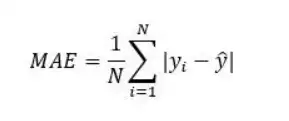

In [35]:
from IPython.display import Image
Image(filename='D:\pierr\Documents\images\mae.png',width=200,height=100)

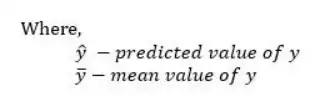

In [36]:
Image(filename='D:\pierr\Documents\images\y.png',width=200,height=100)

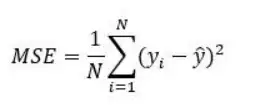

In [37]:
Image(filename='D:\pierr\Documents\images\mse.png',width=200,height=100)

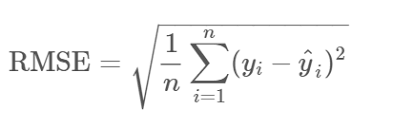

In [38]:
Image(filename='D:\pierr\Documents\images\index.png',width=200,height=100)

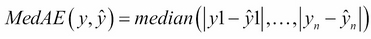

In [39]:
Image(filename='D:\pierr\Documents\images\median.png',width=200,height=200)

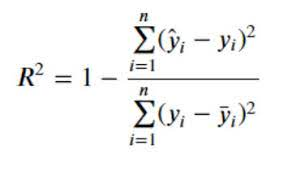

In [40]:
Image(filename='D:\pierr\Documents\images\index.jpg',width=200,height=100)

## Dataframe : 'data_gaz'

In [41]:
y_gaz = data_gaz['GHGEmissionsIntensity']
X_gaz = data_gaz.drop('GHGEmissionsIntensity',axis=1)

X_train_gaz, X_test_gaz, y_train_gaz, y_test_gaz = train_test_split(X_gaz, y_gaz, test_size=0.2,random_state=0)

In [42]:
table_data_gaz = pd.DataFrame(columns=['model','test_score (R2)','RMSE','MAE','median'])
table_data_gaz

,model,test_score (R2),RMSE,MAE,median


In [43]:
#estimation(params_sgd,SGDRegressor,X_train_gaz,X_test_gaz,y_train_gaz,y_test_gaz,X_gaz,y_gaz)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_learning_rate,param_loss,param_penalty,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
76,0.004018,0.003356,0.000806,0.000987,0.01,constant,huber,l2,"{'alpha': 0.01, 'learning_rate': 'constant', '...",0.332243,0.098709,1,0.452525,0.009269
112,0.004020,0.004213,0.002008,0.003106,0.01,constant,huber,l2,"{'alpha': 0.01, 'learning_rate': 'constant', '...",0.332243,0.098709,1,0.452525,0.009269
41,0.005621,0.003890,0.004026,0.003354,0.001,constant,huber,l1,"{'alpha': 0.001, 'learning_rate': 'constant', ...",0.330686,0.168758,3,0.461828,0.019297
90,0.003210,0.003931,0.004430,0.003907,0.01,optimal,huber,elasticnet,"{'alpha': 0.01, 'learning_rate': 'optimal', 'l...",0.330008,0.186053,4,0.461553,0.024616
126,0.009237,0.000990,0.000807,0.000989,0.01,optimal,huber,elasticnet,"{'alpha': 0.01, 'learning_rate': 'optimal', 'l...",0.330008,0.186053,4,0.461553,0.024616


Best params :  {'alpha': 0.01, 'learning_rate': 'constant', 'loss': 'huber', 'penalty': 'l2'}
score train : 0.4382646720356762 score test : 0.1459755691115897
RMSE : 0.6222111777025687
MAE : 0.5498959822428902
median abs err 0.39269030653510983


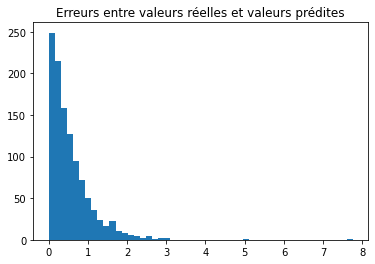

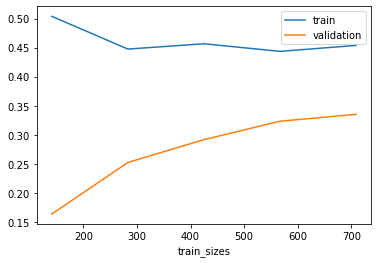

In [44]:
te_score_sgd_gaz,rmse_sgd_gaz,mae_sgd_gaz,median_sgd_gaz = estimation(params_sgd,SGDRegressor,X_train_gaz,X_test_gaz,y_train_gaz,y_test_gaz,X_gaz,y_gaz)

In [47]:
table_data_gaz.loc[0]=['SGDRegressor',te_score_sgd_gaz,rmse_sgd_gaz,mae_sgd_gaz,median_sgd_gaz]
table_data_gaz

,model,test_score (R2),RMSE,MAE,median
0,SGDRegressor,0.145976,0.622211,0.549896,0.39269


In [48]:
#estimation(params_elasticnet,ElasticNet,X_train_gaz,X_test_gaz,y_train_gaz,y_test_gaz,X_gaz,y_gaz)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,param_tol,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
123,0.032140,0.003164,0.000000,0.000000,0.1,0.0,0.0001,"{'alpha': 0.1, 'l1_ratio': 0.0, 'tol': 0.0001}",0.367453,0.109636,1,0.512327,0.004306
122,0.032508,0.003889,0.001603,0.003205,0.1,0.0,0.001,"{'alpha': 0.1, 'l1_ratio': 0.0, 'tol': 0.001}",0.367453,0.109636,1,0.512327,0.004306
120,0.032540,0.003006,0.000404,0.000809,0.1,0.0,0.1,"{'alpha': 0.1, 'l1_ratio': 0.0, 'tol': 0.1}",0.367453,0.109636,1,0.512327,0.004306
121,0.031705,0.003210,0.003611,0.003674,0.1,0.0,0.01,"{'alpha': 0.1, 'l1_ratio': 0.0, 'tol': 0.01}",0.367453,0.109636,1,0.512327,0.004306
127,0.002411,0.003892,0.003212,0.003934,0.1,0.1,0.0001,"{'alpha': 0.1, 'l1_ratio': 0.1, 'tol': 0.0001}",0.367382,0.136526,5,0.500753,0.005951


Best params :  {'alpha': 0.1, 'l1_ratio': 0.0, 'tol': 0.1}
score train : 0.502612119649483 score test : 0.23928878230241224
RMSE : 0.5518732745276623
MAE : 0.5572900754569363
median abs err 0.4464557694588786


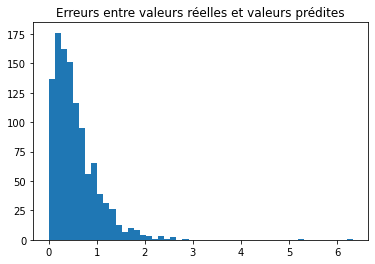

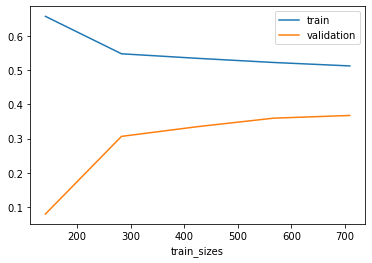

In [49]:
te_score_elastic_gaz,rmse_elastic_gaz,mae_elastic_gaz,median_elastic_gaz = estimation(params_elasticnet,ElasticNet,X_train_gaz,X_test_gaz,y_train_gaz,y_test_gaz,X_gaz,y_gaz)

In [50]:
table_data_gaz.loc[1]=['ElasticNet',te_score_elastic_gaz,rmse_elastic_gaz,mae_elastic_gaz,median_elastic_gaz]
table_data_gaz

,model,test_score (R2),RMSE,MAE,median
0,SGDRegressor,0.145976,0.622211,0.549896,0.392690
1,ElasticNet,0.239289,0.551873,0.557290,0.446456


In [51]:
#estimation_importances(params_random_forest,RandomForestRegressor,X_train_gaz,X_test_gaz,y_train_gaz,y_test_gaz,X_gaz,y_gaz)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
144,0.223743,0.002185,0.008509,0.004324,False,25,sqrt,1,"{'bootstrap': False, 'max_depth': 25, 'max_fea...",0.765579,0.020538,1,0.999864,0.000062
168,0.224980,0.004152,0.012205,0.003169,False,50,sqrt,1,"{'bootstrap': False, 'max_depth': 50, 'max_fea...",0.763602,0.017460,2,1.000000,0.000000
169,0.187024,0.003670,0.010176,0.000067,False,50,sqrt,1,"{'bootstrap': False, 'max_depth': 50, 'max_fea...",0.760009,0.024230,3,0.986844,0.000829
145,0.186688,0.003766,0.010147,0.000057,False,25,sqrt,1,"{'bootstrap': False, 'max_depth': 25, 'max_fea...",0.759366,0.021914,4,0.986060,0.001025
170,0.162848,0.000882,0.010164,0.000064,False,50,sqrt,1,"{'bootstrap': False, 'max_depth': 50, 'max_fea...",0.753972,0.029398,5,0.953182,0.001858


Best params :  {'bootstrap': False, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
score train : 0.9998462653716431 score test : 0.8016570386008253
RMSE : 0.041277642436815296
MAE : 0.06933990833216921
median abs err 0.006464562929949125


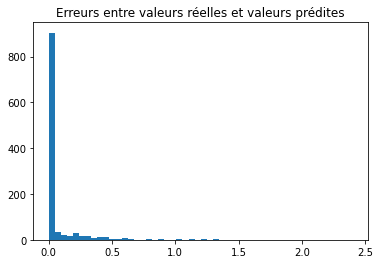

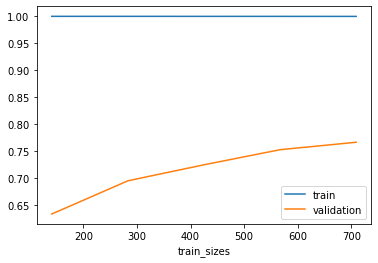

,Features,Importances
12,NaturalGas(kBtu),0.461513
10,ENERGYSTARScore,0.056273
70,x3_Warehouse,0.039175
6,PropertyGFABuilding(s),0.032731
7,LargestPropertyUseTypeGFA,0.031419
4,PropertyGFATotal,0.031221
15,GFAPerFloor,0.030060
1,Longitude,0.030002
0,Latitude,0.027961
11,SteamUse(kBtu),0.023554


Permutation explainer: 888it [02:48,  5.04it/s]                         


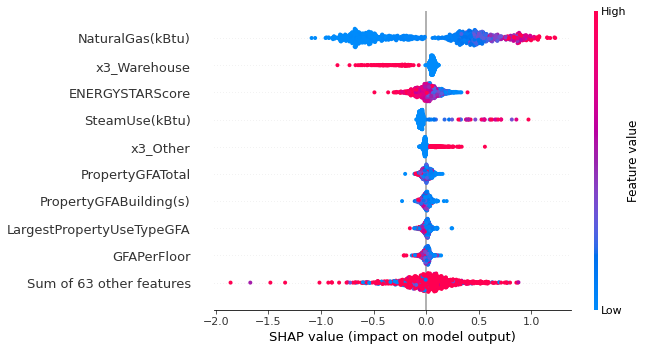

In [52]:
te_score_forest_gaz,rmse_forest_gaz,mae_forest_gaz,median_forest_gaz = estimation_importances(params_random_forest,RandomForestRegressor,X_train_gaz,X_test_gaz,y_train_gaz,y_test_gaz,X_gaz,y_gaz)

In [53]:
table_data_gaz.loc[2]=['RandomForestRegressor',te_score_forest_gaz,rmse_forest_gaz,mae_forest_gaz,median_forest_gaz]
table_data_gaz

,model,test_score (R2),RMSE,MAE,median
0,SGDRegressor,0.145976,0.622211,0.549896,0.392690
1,ElasticNet,0.239289,0.551873,0.557290,0.446456
2,RandomForestRegressor,0.801657,0.041278,0.069340,0.006465


In [54]:
#estimation_importances(param_grid_adaboost,AdaBoostRegressor,X_train_gaz,X_test_gaz,y_train_gaz,y_test_gaz,X_gaz,y_gaz)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_n_estimators,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
17,0.305839,0.018591,0.010555,0.000769,0.1,exponential,100,"{'learning_rate': 0.1, 'loss': 'exponential', ...",0.773591,0.028138,1,0.811658,0.008199
16,0.150602,0.003130,0.006523,0.003705,0.1,exponential,50,"{'learning_rate': 0.1, 'loss': 'exponential', ...",0.769559,0.034292,2,0.805020,0.007831
13,0.284067,0.001292,0.008487,0.003221,0.1,linear,100,"{'learning_rate': 0.1, 'loss': 'linear', 'n_es...",0.766780,0.026791,3,0.810054,0.011670
12,0.150211,0.002541,0.004058,0.003360,0.1,linear,50,"{'learning_rate': 0.1, 'loss': 'linear', 'n_es...",0.764670,0.026677,4,0.804313,0.012417
14,0.144131,0.001316,0.008498,0.000831,0.1,square,50,"{'learning_rate': 0.1, 'loss': 'square', 'n_es...",0.760200,0.022815,5,0.803603,0.010477


Best params :  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}
score train : 0.814553358923541 score test : 0.7629134972115346
RMSE : 0.19610449351866685
MAE : 0.32494896066676165
median abs err 0.24081044158126125


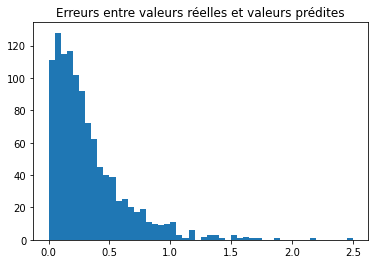

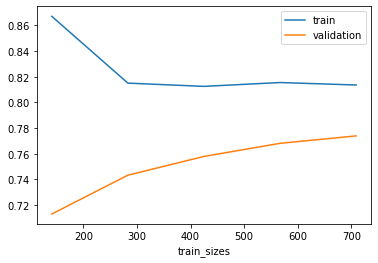

,Features,Importances
12,NaturalGas(kBtu),0.720858
11,SteamUse(kBtu),0.063714
60,x3_Other,0.051039
65,x3_Self-Storage Facility,0.041670
70,x3_Warehouse,0.030787
4,PropertyGFATotal,0.021394
10,ENERGYSTARScore,0.014862
6,PropertyGFABuilding(s),0.013591
67,x3_Small- and Mid-Sized Office,0.008489
33,x1_NORTHEAST,0.006677


Permutation explainer: 888it [04:22,  3.25it/s]                         


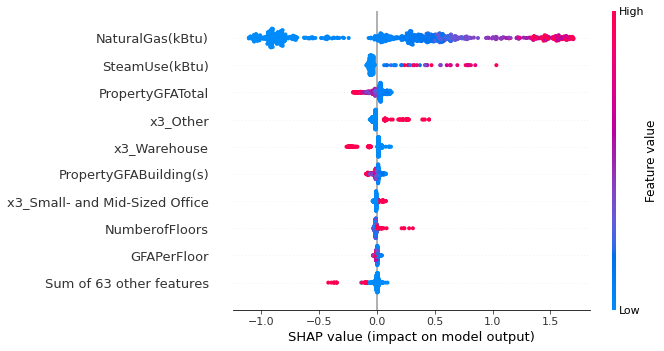

In [55]:
te_score_ada_gaz,rmse_ada_gaz,mae_ada_gaz,median_ada_gaz = estimation_importances(param_grid_adaboost,AdaBoostRegressor,X_train_gaz,X_test_gaz,y_train_gaz,y_test_gaz,X_gaz,y_gaz)

In [56]:
table_data_gaz.loc[3]=['AdaBoosttRegressor',te_score_ada_gaz,rmse_ada_gaz,mae_ada_gaz,median_ada_gaz]
table_data_gaz

,model,test_score (R2),RMSE,MAE,median
0,SGDRegressor,0.145976,0.622211,0.549896,0.392690
1,ElasticNet,0.239289,0.551873,0.557290,0.446456
2,RandomForestRegressor,0.801657,0.041278,0.069340,0.006465
3,AdaBoosttRegressor,0.762913,0.196104,0.324949,0.240810


## Dataframe : 'data_gaz_without_energy'

In [57]:
y_gaz_without_energyscore = data_gaz_without_energyscore['GHGEmissionsIntensity']
X_gaz_without_energyscore = data_gaz_without_energyscore.drop('GHGEmissionsIntensity',axis=1)

X_train_gaz_without_energyscore, X_test_gaz_without_energyscore, y_train_gaz_without_energyscore, y_test_gaz_without_energyscore = train_test_split(X_gaz_without_energyscore, y_gaz_without_energyscore, test_size=0.2,random_state=0)

In [58]:
table_data_gaz_without_energy = pd.DataFrame(columns=['model','test_score (R2)','RMSE','MAE','median'])
table_data_gaz_without_energy

,model,test_score (R2),RMSE,MAE,median


In [59]:
#estimation(params_sgd,SGDRegressor,X_train_gaz_without_energyscore,X_test_gaz_without_energyscore,y_train_gaz_without_energyscore,y_test_gaz_without_energyscore,X_gaz_without_energyscore,y_gaz_without_energyscore)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_learning_rate,param_loss,param_penalty,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
40,0.002008,0.003107,0.002006,0.003105,0.001,constant,huber,l2,"{'alpha': 0.001, 'learning_rate': 'constant', ...",0.303016,0.167103,1,0.448978,0.014516
78,0.002412,0.002948,0.002008,0.003107,0.01,constant,huber,elasticnet,"{'alpha': 0.01, 'learning_rate': 'constant', '...",0.302812,0.099889,2,0.396805,0.021535
114,0.005225,0.003929,0.000000,0.000000,0.01,constant,huber,elasticnet,"{'alpha': 0.01, 'learning_rate': 'constant', '...",0.302812,0.099889,2,0.396805,0.021535
5,0.004024,0.003362,0.000404,0.000808,0.0001,constant,huber,l1,"{'alpha': 0.0001, 'learning_rate': 'constant',...",0.300761,0.181784,4,0.450751,0.015123
4,0.001304,0.002609,0.005133,0.006015,0.0001,constant,huber,l2,"{'alpha': 0.0001, 'learning_rate': 'constant',...",0.299824,0.175962,5,0.451687,0.014646


Best params :  {'alpha': 0.001, 'learning_rate': 'constant', 'loss': 'huber', 'penalty': 'l2'}
score train : 0.43300966028252075 score test : -0.035629873160944125
RMSE : 0.6640570038495289
MAE : 0.5567971721566769
median abs err 0.397749939958554


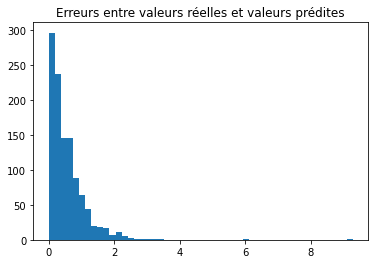

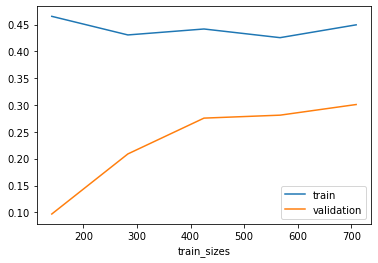

In [60]:
te_score_sgd_gaz_without,rmse_sgd_gaz_without,mae_sgd_gaz_without,median_sgd_gaz_without = estimation(params_sgd,SGDRegressor,X_train_gaz_without_energyscore,X_test_gaz_without_energyscore,y_train_gaz_without_energyscore,y_test_gaz_without_energyscore,X_gaz_without_energyscore,y_gaz_without_energyscore)

In [61]:
table_data_gaz_without_energy.loc[0]=['SGDRegressor',te_score_sgd_gaz_without,rmse_sgd_gaz_without,mae_sgd_gaz_without,median_sgd_gaz_without]
table_data_gaz_without_energy

,model,test_score (R2),RMSE,MAE,median
0,SGDRegressor,-0.03563,0.664057,0.556797,0.39775


In [62]:
#estimation(params_elasticnet,ElasticNet,X_train_gaz_without_energyscore,X_test_gaz_without_energyscore,y_train_gaz_without_energyscore,y_test_gaz_without_energyscore,X_gaz_without_energyscore,y_gaz_without_energyscore)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,param_tol,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
125,0.002710,0.002969,0.002009,0.003111,0.1,0.1,0.01,"{'alpha': 0.1, 'l1_ratio': 0.1, 'tol': 0.01}",0.336169,0.147797,1,0.471595,0.009220
126,0.002009,0.003109,0.003209,0.003256,0.1,0.1,0.001,"{'alpha': 0.1, 'l1_ratio': 0.1, 'tol': 0.001}",0.336103,0.148974,2,0.471454,0.009169
127,0.002411,0.002946,0.002006,0.003106,0.1,0.1,0.0001,"{'alpha': 0.1, 'l1_ratio': 0.1, 'tol': 0.0001}",0.336103,0.149008,3,0.471424,0.009157
123,0.042169,0.003111,0.000000,0.000000,0.1,0.0,0.0001,"{'alpha': 0.1, 'l1_ratio': 0.0, 'tol': 0.0001}",0.331391,0.126297,4,0.482687,0.007697
122,0.038561,0.003209,0.003209,0.003931,0.1,0.0,0.001,"{'alpha': 0.1, 'l1_ratio': 0.0, 'tol': 0.001}",0.331391,0.126297,4,0.482687,0.007697


Best params :  {'alpha': 0.1, 'l1_ratio': 0.1, 'tol': 0.01}
score train : 0.46164072534755785 score test : 0.17877789797052934
RMSE : 0.5968864145694437
MAE : 0.5740884328553393
median abs err 0.45854093370542176


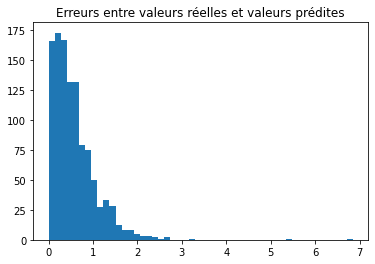

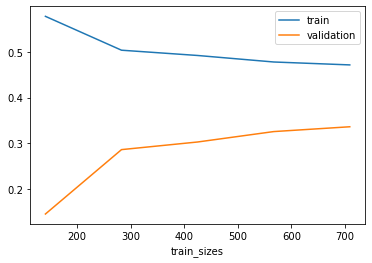

In [63]:
te_score_elastic_gaz_without,rmse_elastic_gaz_without,mae_elastic_gaz_without,median_elastic_gaz_without = estimation(params_elasticnet,ElasticNet,X_train_gaz_without_energyscore,X_test_gaz_without_energyscore,y_train_gaz_without_energyscore,y_test_gaz_without_energyscore,X_gaz_without_energyscore,y_gaz_without_energyscore)

In [64]:
table_data_gaz_without_energy.loc[1]=['ElasticNet',te_score_elastic_gaz_without,rmse_elastic_gaz_without,mae_elastic_gaz_without,median_elastic_gaz_without]
table_data_gaz_without_energy

,model,test_score (R2),RMSE,MAE,median
0,SGDRegressor,-0.035630,0.664057,0.556797,0.397750
1,ElasticNet,0.178778,0.596886,0.574088,0.458541


In [65]:
#estimation_importances(params_random_forest,RandomForestRegressor,X_train_gaz_without_energyscore,X_test_gaz_without_energyscore,y_train_gaz_without_energyscore,y_test_gaz_without_energyscore,X_gaz_without_energyscore,y_gaz_without_energyscore)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
168,0.228776,0.003597,0.010163,0.000062,False,50,sqrt,1,"{'bootstrap': False, 'max_depth': 50, 'max_fea...",0.764964,0.026120,1,1.000000,0.000000
169,0.187019,0.004101,0.008069,0.004035,False,50,sqrt,1,"{'bootstrap': False, 'max_depth': 50, 'max_fea...",0.761256,0.026753,2,0.985165,0.000875
144,0.218444,0.007000,0.012964,0.005692,False,25,sqrt,1,"{'bootstrap': False, 'max_depth': 25, 'max_fea...",0.761198,0.022822,3,0.999624,0.000090
145,0.184572,0.003133,0.005687,0.004703,False,25,sqrt,1,"{'bootstrap': False, 'max_depth': 25, 'max_fea...",0.761111,0.026773,4,0.983500,0.001115
170,0.167808,0.008185,0.008926,0.005100,False,50,sqrt,1,"{'bootstrap': False, 'max_depth': 50, 'max_fea...",0.754193,0.024897,5,0.950102,0.001638


Best params :  {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
score train : 1.0 score test : 0.7858561466959011
RMSE : 0.044434515455083784
MAE : 0.06546929978610683
median abs err 7.771561172376096e-16


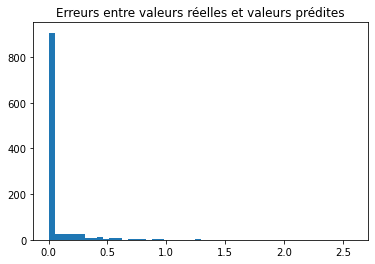

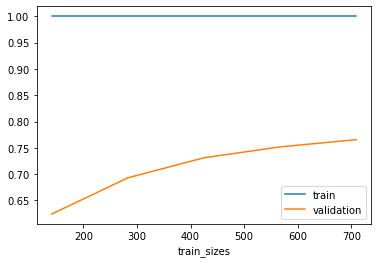

,Features,Importances
11,NaturalGas(kBtu),0.482693
69,x3_Warehouse,0.036230
4,PropertyGFATotal,0.033919
6,PropertyGFABuilding(s),0.033530
14,GFAPerFloor,0.033318
1,Longitude,0.033195
7,LargestPropertyUseTypeGFA,0.032715
0,Latitude,0.032130
10,SteamUse(kBtu),0.025129
8,SecondLargestPropertyUseTypeGFA,0.021298


Permutation explainer: 888it [03:20,  4.21it/s]                         


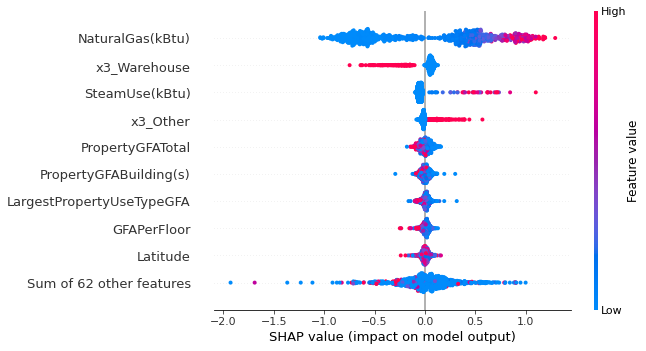

In [66]:
te_score_forest_gaz_without,rmse_forest_gaz_without,mae_forest_gaz_without,median_forest_gaz_without = estimation_importances(params_random_forest,RandomForestRegressor,X_train_gaz_without_energyscore,X_test_gaz_without_energyscore,y_train_gaz_without_energyscore,y_test_gaz_without_energyscore,X_gaz_without_energyscore,y_gaz_without_energyscore)

In [67]:
table_data_gaz_without_energy.loc[2]=['RandomForestRegressor',te_score_forest_gaz_without,rmse_forest_gaz_without,mae_forest_gaz_without,median_forest_gaz_without]
table_data_gaz_without_energy

,model,test_score (R2),RMSE,MAE,median
0,SGDRegressor,-0.035630,0.664057,0.556797,3.977499e-01
1,ElasticNet,0.178778,0.596886,0.574088,4.585409e-01
2,RandomForestRegressor,0.785856,0.044435,0.065469,7.771561e-16


In [68]:
#estimation_importances(param_grid_adaboost,AdaBoostRegressor,X_train_gaz_without_energyscore,X_test_gaz_without_energyscore,y_train_gaz_without_energyscore,y_test_gaz_without_energyscore,X_gaz_without_energyscore,y_gaz_without_energyscore)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_n_estimators,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
17,0.279230,0.004838,0.010289,0.000325,0.1,exponential,100,"{'learning_rate': 0.1, 'loss': 'exponential', ...",0.776089,0.031168,1,0.813055,0.007019
16,0.142346,0.001606,0.008259,0.004280,0.1,exponential,50,"{'learning_rate': 0.1, 'loss': 'exponential', ...",0.773628,0.031165,2,0.806023,0.007698
12,0.144682,0.003823,0.006081,0.004221,0.1,linear,50,"{'learning_rate': 0.1, 'loss': 'linear', 'n_es...",0.772628,0.025982,3,0.808569,0.006193
13,0.277553,0.006391,0.012003,0.003417,0.1,linear,100,"{'learning_rate': 0.1, 'loss': 'linear', 'n_es...",0.766687,0.033205,4,0.808765,0.008046
14,0.143262,0.001059,0.005295,0.004362,0.1,square,50,"{'learning_rate': 0.1, 'loss': 'square', 'n_es...",0.755252,0.034100,5,0.800510,0.002774


Best params :  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}
score train : 0.8101898225063142 score test : 0.7653744416094164
RMSE : 0.19905061165130472
MAE : 0.32009566987720867
median abs err 0.22392167663725498


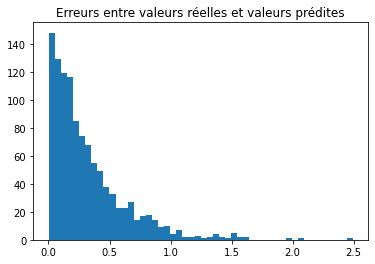

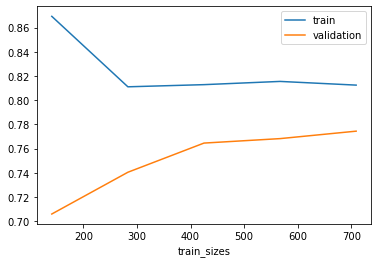

,Features,Importances
11,NaturalGas(kBtu),0.707646
10,SteamUse(kBtu),0.066014
59,x3_Other,0.059033
64,x3_Self-Storage Facility,0.044324
69,x3_Warehouse,0.029880
4,PropertyGFATotal,0.025178
3,NumberofFloors,0.010895
66,x3_Small- and Mid-Sized Office,0.009728
7,LargestPropertyUseTypeGFA,0.009675
14,GFAPerFloor,0.009538


Permutation explainer: 888it [04:48,  2.97it/s]                         


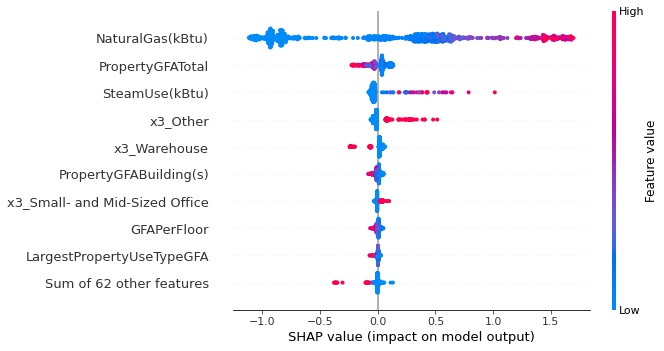

In [69]:
te_score_ada_gaz_without,rmse_ada_gaz_without,mae_ada_gaz_without,median_ada_gaz_without = estimation_importances(param_grid_adaboost,AdaBoostRegressor,X_train_gaz_without_energyscore,X_test_gaz_without_energyscore,y_train_gaz_without_energyscore,y_test_gaz_without_energyscore,X_gaz_without_energyscore,y_gaz_without_energyscore)

In [70]:
table_data_gaz_without_energy.loc[3]=['AdaBoostRegressor',te_score_ada_gaz_without,rmse_ada_gaz_without,mae_ada_gaz_without,median_ada_gaz_without]
table_data_gaz_without_energy

,model,test_score (R2),RMSE,MAE,median
0,SGDRegressor,-0.035630,0.664057,0.556797,3.977499e-01
1,ElasticNet,0.178778,0.596886,0.574088,4.585409e-01
2,RandomForestRegressor,0.785856,0.044435,0.065469,7.771561e-16
3,AdaBoostRegressor,0.765374,0.199051,0.320096,2.239217e-01


## Conclusion